# FYP Assignment 02 - Hyperparameter Tuning - MNIST Digits

In [1]:
# Basic libs
import numpy as np
import pandas as pd

# matplotlib setup for plotting
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

## Loading Dataset

In [2]:
from keras.datasets import mnist

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Train-test split has already been done for us
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Before proceeding, make sure you didn't mess up the order of tuple unpacking
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [5]:
# Sanity check: 60k-10k split?
print(f"Number of training samples: {len(X_train)}")
print(f"Number of test samples: {len(X_test)}")

Number of training samples: 60000
Number of test samples: 10000


## Visualizing a Single Image

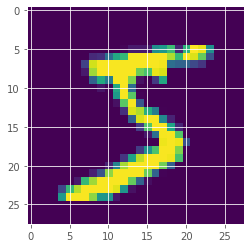

In [6]:
test_image = X_train[0]
plt.figure()
plt.imshow(test_image, cmap='viridis')

In [7]:
# Shape of images and labels?
print("Training image shape: ", test_image.shape)
print("Maximum value in image: ", test_image.max())
print("Minimum value in image: ", test_image.min())

Training image shape:  (28, 28)
Maximum value in image:  255
Minimum value in image:  0


Images will have to be unrolled or flattened before being fed to simple feedforward neural network. The pixel intensities should also be scaled.

## Class Distribution
Do both training and test sets contain roughly the same proportions of samples for each class?

In [8]:
# Training data 
y_train_counts = pd.DataFrame(data={'labels': y_train})['labels'].value_counts(normalize=True)

# Test data
y_test_counts = pd.DataFrame(data={'labels': y_test})['labels'].value_counts(normalize=True)

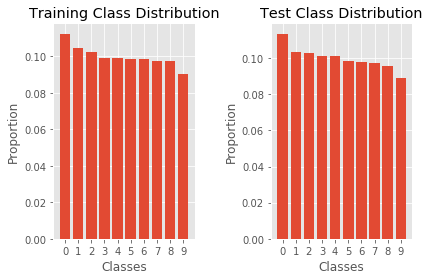

In [9]:
# Plotting normalized training and test set label counts side by side for comparison

# Training
plt.subplot(121)
plt.bar(np.unique(y_train), y_train_counts)
plt.xticks(np.unique(y_train))
plt.xlabel('Classes')
plt.ylabel('Proportion')
plt.title('Training Class Distribution')

# Test
plt.subplot(122)
plt.bar(np.unique(y_test), y_test_counts)
plt.xticks(np.unique(y_test))
plt.xlabel('Classes')
plt.ylabel('Proportion')
plt.title('Test Class Distribution')

plt.tight_layout()

Both training and test set label distributions are roughly identical, which means that we don't need to carry out stratified sampling for the training set results to be applicable to the test set data. 

## Building Preprocessing Pipeline
Data preprocessing for this model includes
1. 'Unrolling' or flattening the 28x28 images into 784-dimensional vectors of pixel intensities.
2. Pixel values should also be scaled.

Since feature scaling strategy is a hyperparameter, defining a custom data transformer class called `FeatureScaler` that will use a different scaling strategy based on an initializer argument.

## Preprocessing

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [14]:
# Defining a custom preprocessing pipeline that changes feature scaling based on str argument
class FeatureScaler(BaseEstimator, TransformerMixin):
    """Based on initializer argument, uses a different feature scaling function for data"""
    def __init__(self, scaling_strategy='Standard'):
        """Instantiates chosen scaling strategy as an instance method"""
        self.scaling_strategy = scaling_strategy
        
    def fit(self, X, y=None):
        # Nothing to do
        return self
    
    def transform(self, X, y=None):
        """Uses defined strategy to scale input features"""
        if (self.scaling_strategy == 'MinMax'):
            return (X - X.mean()) / (X.max() - X.min())
        elif (self.scaling_strategy == 'MaxAbs'):
            return X / (np.max(np.abs(X)))
        else:
            return (X - X.mean()) / (X.std())

In [15]:
# Easier to just cast to float32 with broadcasting
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [16]:
# Sanity check function for pipeline transformer
def checkScaledFeatures(X, scaler):
    pipeline = Pipeline([
        ('FeatureScaler', FeatureScaler(scaling_strategy=scaler))
    ])
    X_transformed = pipeline.fit_transform(X)
    print(f"================={scaler.upper()}=================")
    print(f"Shape of {scaler} transformed data: {len(X_transformed.shape)}")
    print(f"Min value of {scaler} transformed data: {X_transformed.min()}")
    print(f"Max value of {scaler} transformed data: {X_transformed.max()}")
    print(f"Mean value of {scaler} transformed data: {X_transformed.mean()}")
    print(f"Std of {scaler} transformed data: {X_transformed.std()}")

In [17]:
checkScaledFeatures(X_train, scaler='Standard')
checkScaledFeatures(X_train, scaler='MinMax')
checkScaledFeatures(X_train, scaler='MaxAbs')

=================STANDARD=================
Shape of Standard transformed data: 3
Min value of Standard transformed data: -0.4240744709968567
Max value of Standard transformed data: 2.821544647216797
Mean value of Standard transformed data: -3.456026433923398e-07
Std of Standard transformed data: 0.9999998211860657
=================MINMAX=================
Shape of MinMax transformed data: 3
Min value of MinMax transformed data: -0.13066057860851288
Max value of MinMax transformed data: 0.8693394064903259
Mean value of MinMax transformed data: -9.705549786076517e-08
Std of MinMax transformed data: 0.30810776352882385
=================MAXABS=================
Shape of MaxAbs transformed data: 3
Min value of MaxAbs transformed data: 0.0
Max value of MaxAbs transformed data: 1.0
Mean value of MaxAbs transformed data: 0.13066062331199646
Std of MaxAbs transformed data: 0.30810776352882385


In [46]:
from tensorflow.keras.utils import to_categorical

In [47]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Base Model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [49]:
base_model = Sequential()

# Convolutional base
base_model.add(Conv2D(filters=32, input_shape=(28, 28, 1), kernel_size=(2, 2)))
base_model.add(MaxPooling2D((2, 2)))
base_model.add(Conv2D(filters=64, kernel_size=(2, 2)))
base_model.add(MaxPooling2D((2, 2)))

# Densely connected classifier
base_model.add(Flatten())
base_model.add(Dense(units=128, activation='relu'))
base_model.add(Dense(units=10, activation='softmax'))

In [50]:
base_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
base_model_pipeline = Pipeline([
    ('FeatureScaler', FeatureScaler(scaling_strategy='MinMax'))
])

In [55]:
X_train_minmax = base_model_pipeline.fit_transform(X_train)

In [56]:
# Add channels axis
X_train_minmax = X_train_minmax.reshape(len(X_train_minmax),
                                       X_train_minmax.shape[1],
                                       X_train_minmax.shape[2],
                                       1)

In [57]:
base_model_history = base_model.fit(X_train_minmax, y_train,
                                   batch_size=128, epochs=12,
                                   validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 26s 536us/sample - loss: 0.2354 - accuracy: 0.9264 - val_loss: 0.0962 - val_accuracy: 0.9722
Epoch 2/12
48000/48000 [==============================] - 23s 484us/sample - loss: 0.0638 - accuracy: 0.9807 - val_loss: 0.0615 - val_accuracy: 0.9821
Epoch 3/12
14976/48000 [========>.....................] - ETA: 16s - loss: 0.0395 - accuracy: 0.9883

KeyboardInterrupt: 

In [58]:
import os

In [ ]:
os.makedir(os.path.join(os.getcwd(), ''))

In [ ]:

abase_model.save('./models')